# Spatial Imaging dv/v
spatial imaging by means of a diffusion-based sensitivity kernel (see Obermann, et al., 2013 and Pacheco and Snieder, 2005)

Implementation here is just for the 2D case

Reproduces figures from Makus et al., 2024. The actual computations are done in the scripts

In [2]:
proj_dir = '.'

### L Curve

2023-04-02T07:30:00.000000Z
[0.0005 0.001  0.002  0.004  0.008  0.016  0.032  0.064  0.128 ]
[0.25, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0]


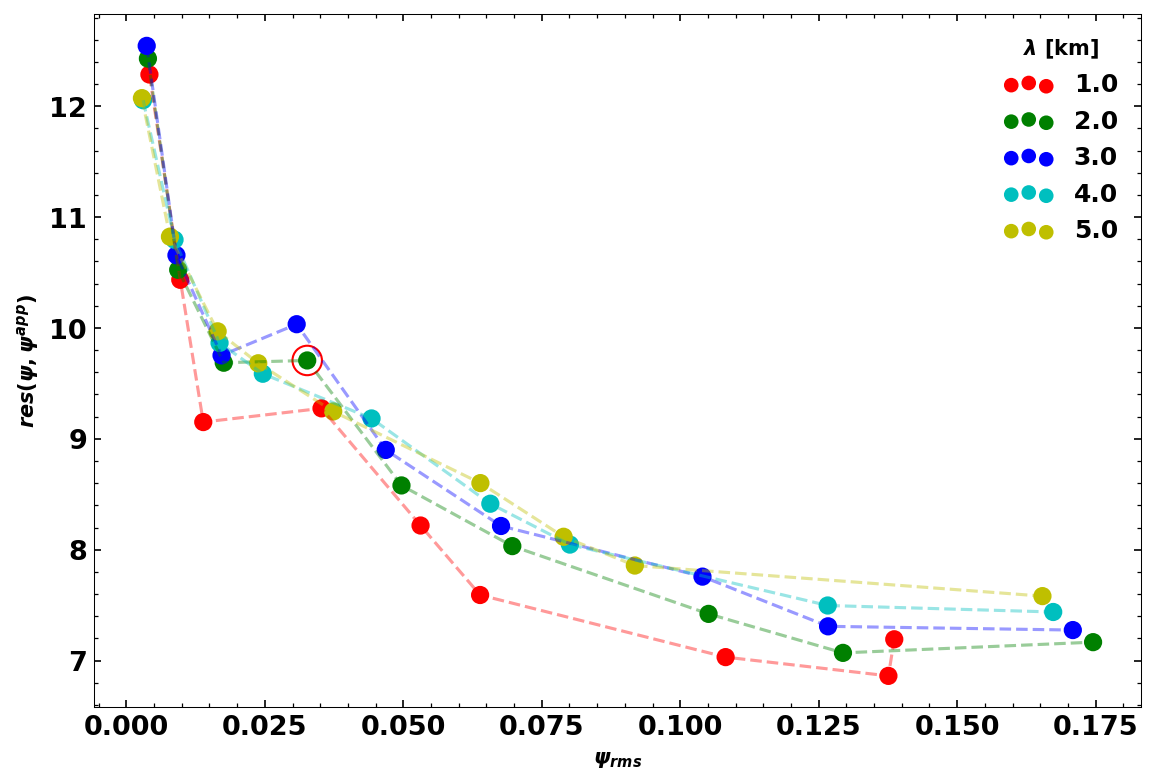

In [93]:
import os
import numpy as np
from matplotlib import pyplot as plt

from seismic.plot.plot_utils import set_mpl_params

filename = 'Lcurve_1.0'  # input and output

lc = np.load(
    os.path.join(
        proj_dir,
        f'spatial/lcurve/{filename}.npz'))
outfolder = os.path.join(
    proj_dir,
    'figures',
    'lcurves',)
os.makedirs(outfolder, exist_ok=True)
corrl_grid = lc['corr_len']
stdg = lc['std_model']

residual = lc['residual']
rms = lc['rms']
times = lc['times']
vel_change = lc['vel_change']

set_mpl_params()

# 6 colours, 5 shapes
plt.figure(figsize=(9, 6))
ax = plt.gca()

ii = corrl_grid >= 1

rms_to_plot = rms[...,-2]
residual_to_plot = residual[...,-2]

colorlist = ['r', 'g', 'b', 'c', 'y']

for stdm in np.sort(np.unique(stdg)):

    scatter = plt.scatter(
        rms_to_plot[np.all((stdg==stdm, ii), axis=0)],
        residual_to_plot[np.all((stdg==stdm, ii), axis=0)],
        c=colorlist,
        s=60,
        marker='o')

# connect point belonging to same corr_len
for jj, corrl in enumerate(np.sort(np.unique(corrl_grid[ii]))):
    plt.plot(
        rms_to_plot[np.all((corrl_grid==corrl, ii), axis=0)],
        residual_to_plot[np.all((corrl_grid==corrl, ii), axis=0)],
        linestyle='--', color=colorlist[jj],
        alpha=0.4
    )
    plt.scatter(np.nan, np.nan, color=colorlist[jj], label=corrl)
plt.legend(loc='upper right', title=r"$\lambda$ [km]")


# produce a legend with a cross-section of sizes from the scatter
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)

scatter = plt.scatter(
    rms_to_plot[np.all((stdg==0.004, corrl_grid==2), axis=0)],
    residual_to_plot[np.all((stdg==0.004, corrl_grid==2), axis=0)],
    edgecolors='r', s=200, facecolors='none', marker='o')

plt.ylabel(r'$res(\psi, \psi^{app})$')
plt.xlabel(r'$\psi_{rms}$')
plt.savefig(f'{outfolder}/{filename}.pdf', bbox_inches='tight', facecolor='None')

## Time-dependent dv/v map

In [8]:
import glob
import os

import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
from obspy import UTCDateTime
from scipy.signal import butter, sosfiltfilt, detrend


freq0 = 0.5
corr_len = 2
std_model = 0.004

infile = glob.glob(os.path.join(
    proj_dir,
    f'spatial{corr_len}_std{std_model}/{freq0}-*/dvdt_3D.npz'))[0]

outfolder = os.path.join(os.path.dirname(os.path.dirname(infile)), 'figures')
os.makedirs(outfolder, exist_ok=True)

loaded = np.load(infile)

x = loaded['xaxis']
y = loaded['yaxis']
t = loaded['taxis']
dv = loaded['dv']

statx = loaded['statx']
staty = loaded['staty']
# No data anymore from this date on
start = 0  # 4 for february # Start here for February
start = np.argmin(abs(t - UTCDateTime('2007-06-01').timestamp))
end = np.argmin(abs(t - UTCDateTime('2023-06-01').timestamp))

try:
    res = loaded['resolution']
except KeyError:
    res = None
utcs = [UTCDateTime(tt) for tt in t]
datetimes = [utci.datetime for utci in utcs]
dv_total = dv[..., end]-dv[..., start]

#### Plot this using PyGMT

In [9]:
# interpolate the data from the algorithm, back onto lat and lon
from obspy.geodetics import kilometer2degrees as km2d
from obspy.geodetics import degrees2kilometers as d2km
from obspy.geodetics import locations2degrees as loc2d
from xarray import DataArray
import pygmt

lat0 = 46.05
lat = km2d(y) + lat0
lat0 = lat.min()
lon0 = -122.45 # -122.34
# find out how many degree 1km is
km2lon = 1/d2km(loc2d(lat0, 1, lat0, 0))
lon = km2lon*(x-x.min())+lon0

region = [lon.min(), lon.max(), lat.min(), lat.max()]
topo = pygmt.datasets.load_earth_relief(resolution="03s", region=region)
# topo is returned as lines are latitude and columns longitude


pygmt-session [WARNING]: Remote dataset given to a data processing module but no registration was specified - default to gridline registration (if available)
grdcut [WARNING]: (e - x_min) must equal (NX + eps) * x_inc), where NX is an integer and |eps| <= 0.0001.
grdcut [WARNING]: e reset from -122.022384584 to -122.021666667
grdcut [WARNING]: (n - y_min) must equal (NY + eps) * y_inc), where NY is an integer and |eps| <= 0.0001.
grdcut [WARNING]: n reset from 46.3647625621 to 46.365


In [10]:
from scipy.interpolate import RegularGridInterpolator

latq = topo.coords['lat'].data
lonq = topo.coords['lon'].data


lonqg, latqg = np.meshgrid(lonq, latq)
qcoords = np.array([np.array([la, lo]) for lo, la in zip(lonqg.flatten(), latqg.flatten())])

f = RegularGridInterpolator((lat, lon), dv_total, bounds_error=False, method='linear')


# mark the pixels that we use for the 1D comparisons
m = dv_total.shape[0]-4
n = dv_total.shape[1]//2

m2 = 15
n2 = 19

dv_totalint = f(qcoords)
dv_totalint = dv_totalint.reshape(latqg.shape)

dv_total_grid = DataArray(data=dv_totalint*-100, coords={'lon': lonq, 'lat': latq}, dims=('lat', 'lon'), name='dv/v')

makecpt [WARNING]: Without inc in -T option, -Z has no effect (ignored)


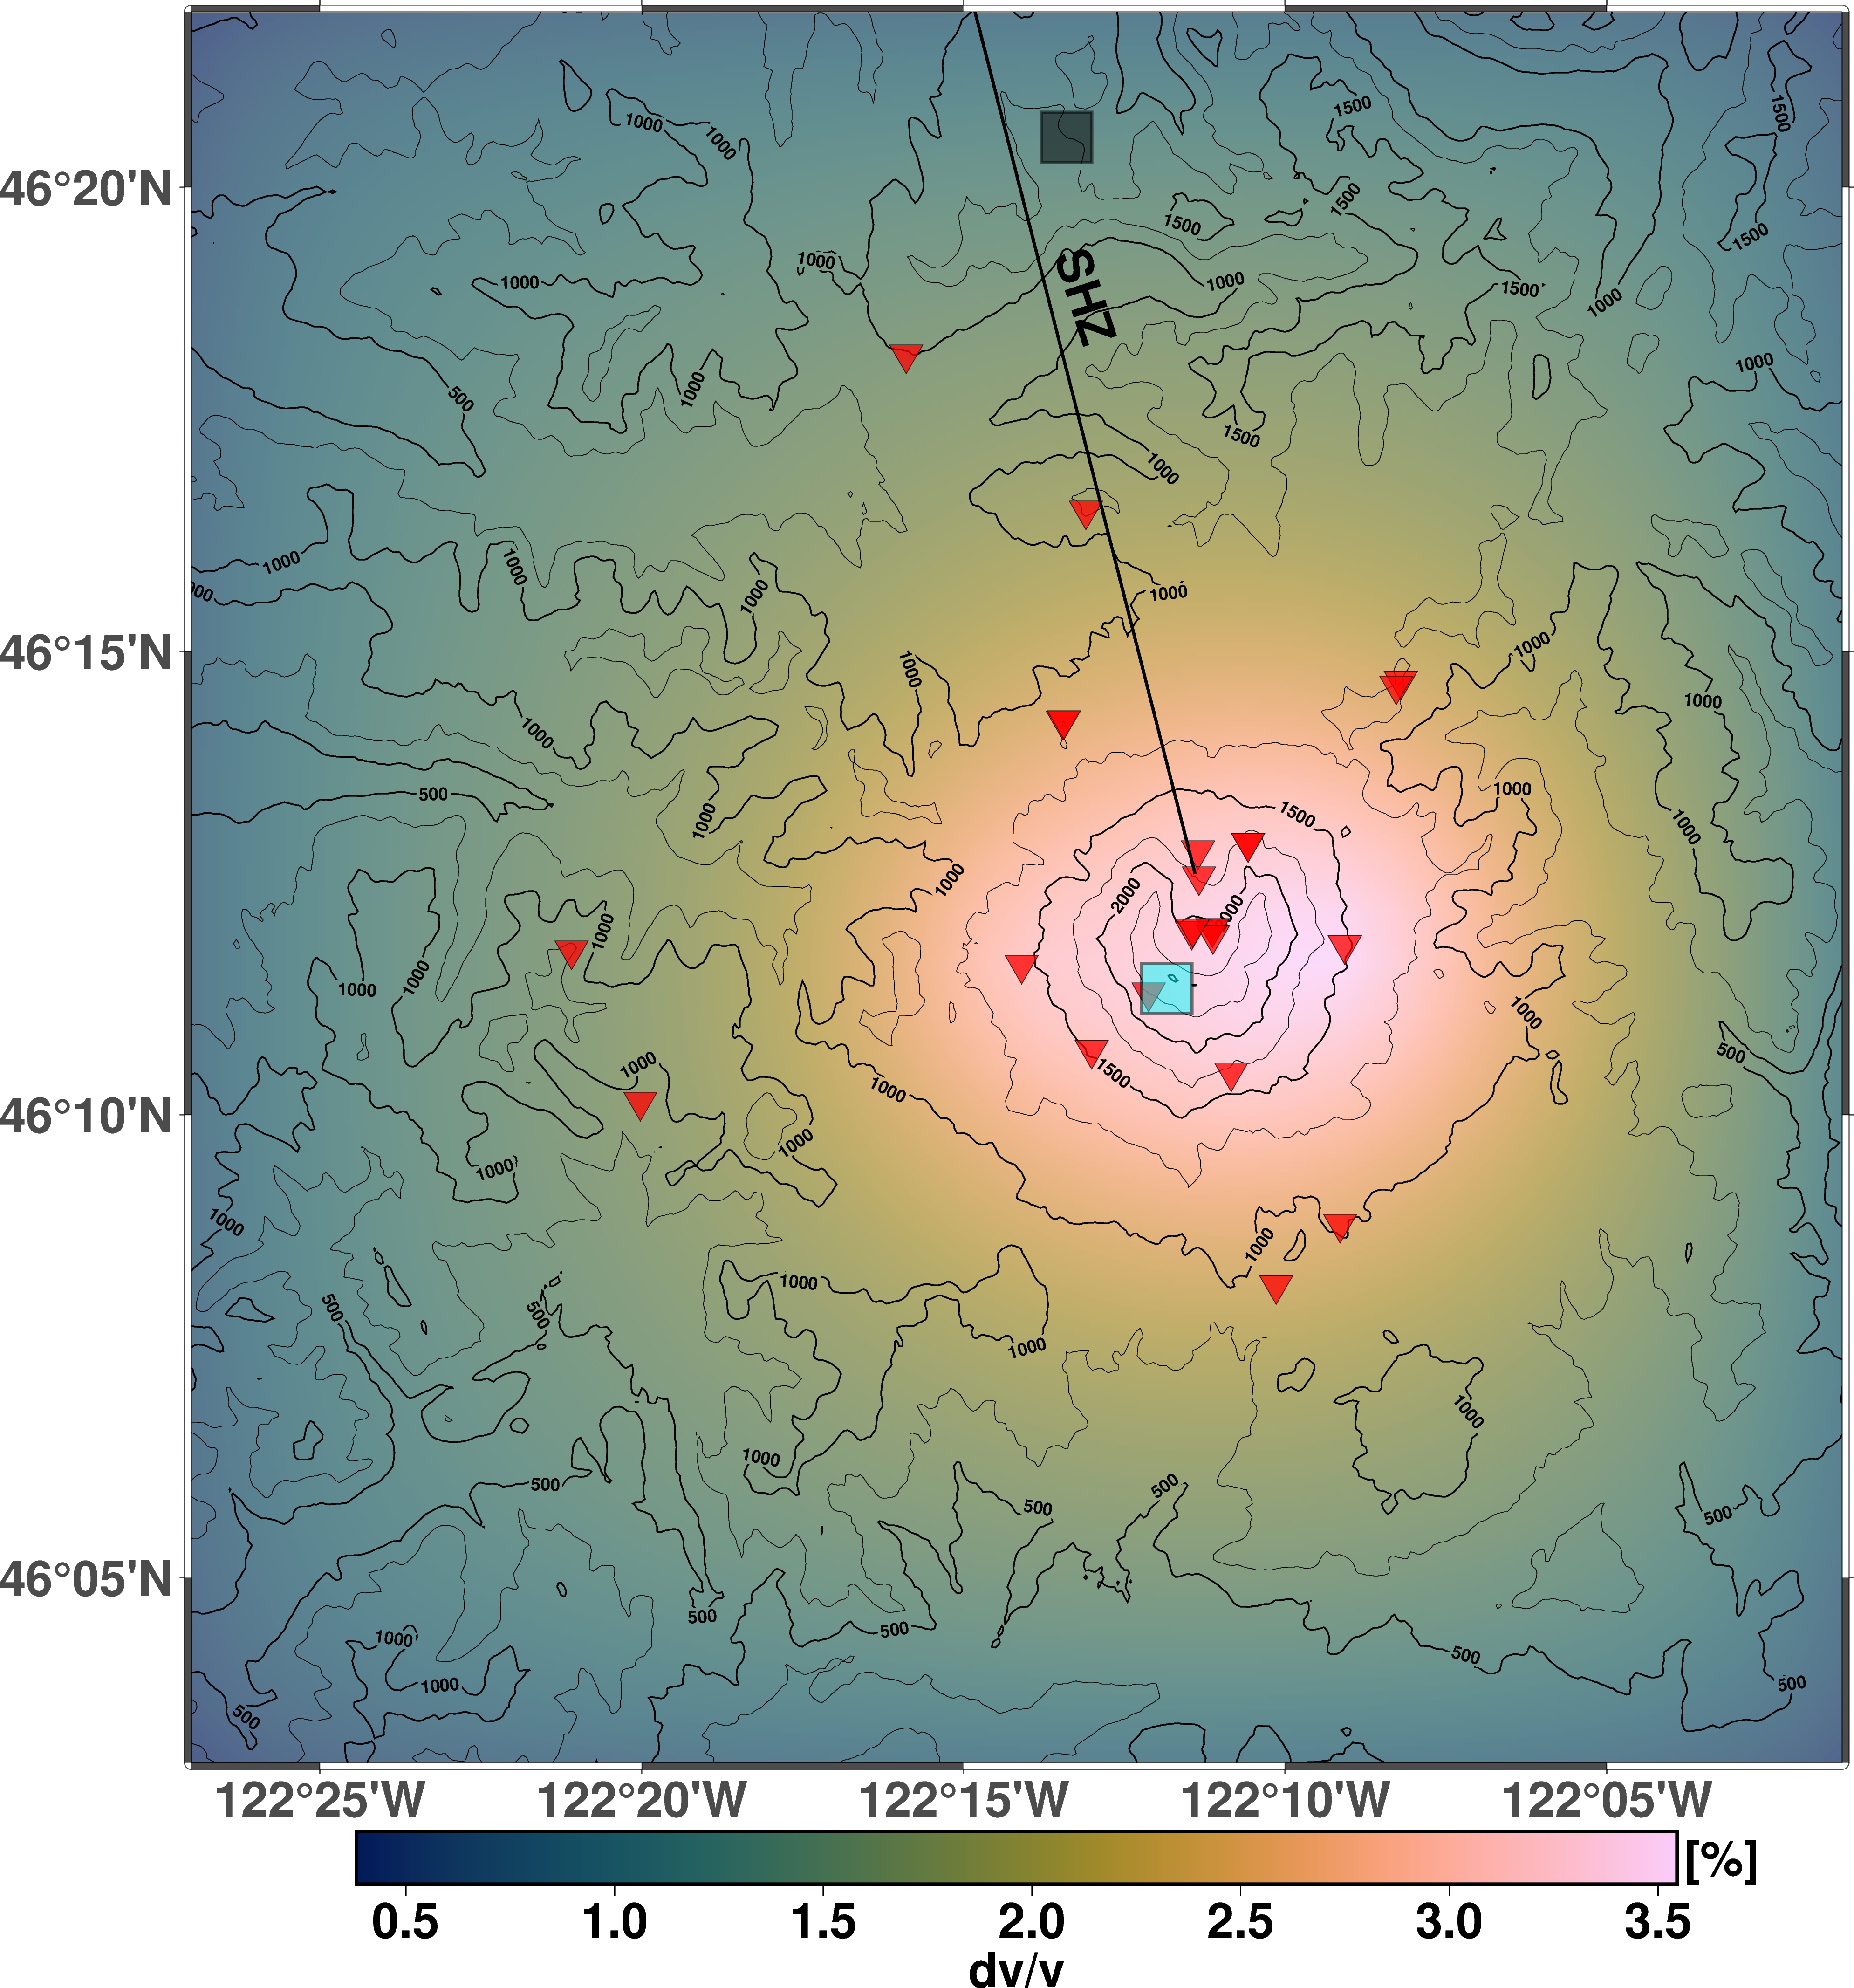

In [11]:
# pygmt.config() #'13p')
import os
import pandas as pd

stats = pd.read_csv('stat_locs.txt', sep='|', header=0, skipinitialspace=True)


fig = pygmt.Figure()
# create colorbar for xarray.DataArray
absmax = np.max(abs(dv_total))
pygmt.makecpt(
    # cmap="red,white,blue",
    cmap='batlow',
    series=f"{-dv_total.max()*100}/{absmax*100+.01}",
    continuous=True,
    reverse=False,
)

persp = [160, 30] #40
persp = [180, 90] #40

proj = "M30c"

cb_tick_increment = round(
    (dv_total.max() - dv_total.min())*100/7,
    int(-np.floor(np.log10(100*(dv_total.max() - dv_total.min()))) + 1))

surftype = 'i'
with pygmt.config(
    MAP_FRAME_TYPE='fancy+',
        FONT='25p,Helvetica-Bold'):
    dgrid = pygmt.grdgradient(grid=topo, radiance=[270, 1])
    # add contour lines
    
    fig.grdimage(
        grid=dv_total_grid,
        # Sets the view azimuth as 130 degrees, and the view elevation as 30
        # degrees
        perspective=persp, #160 50
        region=region,
        # Sets the x- and y-axis labels, and annotates the west, south, and east
        # axes
        frame='a',
        # Sets a Mercator projection on a 15-centimeter figure
        projection=proj,
        # Sets the height of the three-dimensional relief centimeters
        transparency=30,
        interpolation='n'
    )
    fig.grdcontour(
        annotation=500,
        interval=250,
        grid=topo,
    )
    fig.colorbar(frame=[f'a{cb_tick_increment}', "x+ldv/v", "y+l[%]"], projection=proj)
    fig.plot(
        x=stats.Longitude, y=stats.Latitude, style="i0.7c", color="red", pen="black", transparency=25, projection=proj)
    # plot st helens seismic zone
    fig.plot(
        # region=[0, 10, 0, 10],
        # projection="X15c/10c",
        # frame="a",
        x=[-122.19, -122.26],
        y=[46.21, 46.4],
        pen="1.5p,black",
    )
    # plot a box around the pixel areas around m and n
    # and fill it
    fig.plot(
        x=[lon[n], lon[n], lon[n+1], lon[n+1], lon[n]],
        y=[lat[m], lat[m+1], lat[m+1], lat[m], lat[m]],
        pen="1.5p,black", color="black", transparency=50,
    )
    fig.plot(
        x=[lon[n2], lon[n2], lon[n2+1], lon[n2+1], lon[n2]],
        y=[lat[m2], lat[m2+1], lat[m2+1], lat[m2], lat[m2]],
        pen="1.5p,black", color="cyan", transparency=50,
    )
    fig.text(text='SHZ', angle=-72, x=-122.225, y=46.32, font='Helvetica-Bold', justify='LM', offset='0.2c')
fig.show()

# Local quakes
check for correlations in the dv/v trend and the number of earthquake occurences (and their depths)

In [12]:
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
from obspy.core.event.catalog import Catalog
import numpy as np
from obspy import read_events


minmag = -1
try:
    evts = read_events(f'MSH_events_minmag{minmag}.xml')
except FileNotFoundError:
    c = Client('USGS', timeout=240)

    lat = [45.95, 46.45]
    lon = [-122.45, -121.96]


    starttime = UTCDateTime(year=2007, julday=1)
    endtime = UTCDateTime(year=2023, julday=365)
    delta = 86400*365
    rtimes = np.linspace(starttime.timestamp, endtime.timestamp, 12)
    # rtimes = np.arange(starttime.timestamp, endtime.timestamp, delta)
    evts = Catalog()



    for ii, rtime in enumerate(rtimes):
        if ii == len(rtimes)-1:
            break
        start = UTCDateTime(rtime)
        end = UTCDateTime(rtimes[ii+1])
        print(f'downloading events from {start} to {end}')
        evts.extend(c.get_events(
            starttime=start, endtime=end, minmagnitude=minmag, maxdepth=15,
            minlatitude=lat[0], maxlatitude=lat[1], minlongitude=lon[0],
            maxlongitude=lon[1]))
    evts.write(f'MSH_events_minmag{minmag}.xml', format='QUAKEML')

otimes = [evt.preferred_origin().time.datetime for evt in evts]
hypz = [-evt.preferred_origin().depth for evt in evts]


downloading events from 2007-01-01T00:00:00.000000Z to 2008-07-18T08:43:38.181818Z


KeyboardInterrupt: 

### plot events vs dv/v curve

In [ ]:
# load dv/v data for all frequencies
import glob
import os

import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
from obspy import UTCDateTime


freq0 = 0.5
corr_len = 2
std_model = 0.004
dv = {}
for freq0, std_model in zip([0.25, 0.5, 1.0], [0.004, 0.004, 0.004]):
    infile = glob.glob(
        f'/home/pm/Documents_sync/PhD/StHelens/spatial/linearised/new_gap_handling_crosssingle_dvfilt_allcc_cl{corr_len}_std{std_model}_largemap/{freq0}-*/dvdt_3D.npz')[0]

    loaded = np.load(infile)

    x = loaded['xaxis']
    y = loaded['yaxis']
    t = loaded['taxis']
    dvdt = loaded['dv']

    dv[freq0] = -100*dvdt[15, 19]
datetimes = [UTCDateTime(tt).datetime for tt in t]


In [ ]:
# number of earthquakes in the two discussed periods
high_activity = (datetime.datetime(2013, 1, 1), datetime.datetime(2019, 1, 1))
low_activity = (datetime.datetime(2019, 1, 1), datetime.datetime(2022, 1, 1))

# compute number of earthquakes for the two times
otimes = [evt.preferred_origin().time.datetime for evt in evts]

# for high_activity:
n_eqs_high_activity = len([ot for ot in otimes if high_activity[0] < ot < high_activity[1]])

n_eqs_low_activity = len([ot for ot in otimes if low_activity[0] < ot < low_activity[1]])

# divide by number of years
n_eqs_high_activity /= (high_activity[1]-high_activity[0]).days/365
n_eqs_low_activity /= (low_activity[1]-low_activity[0]).days/365

print(f'Number of earthquakes p.a. in high activity period: {n_eqs_high_activity}')
print(f'Number of earthquakes p.a. in low activity period: {n_eqs_low_activity}')

Number of earthquakes p.a. in high activity period: 560.0775901414879
Number of earthquakes p.a. in low activity period: 346.01733576642334


In [ ]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

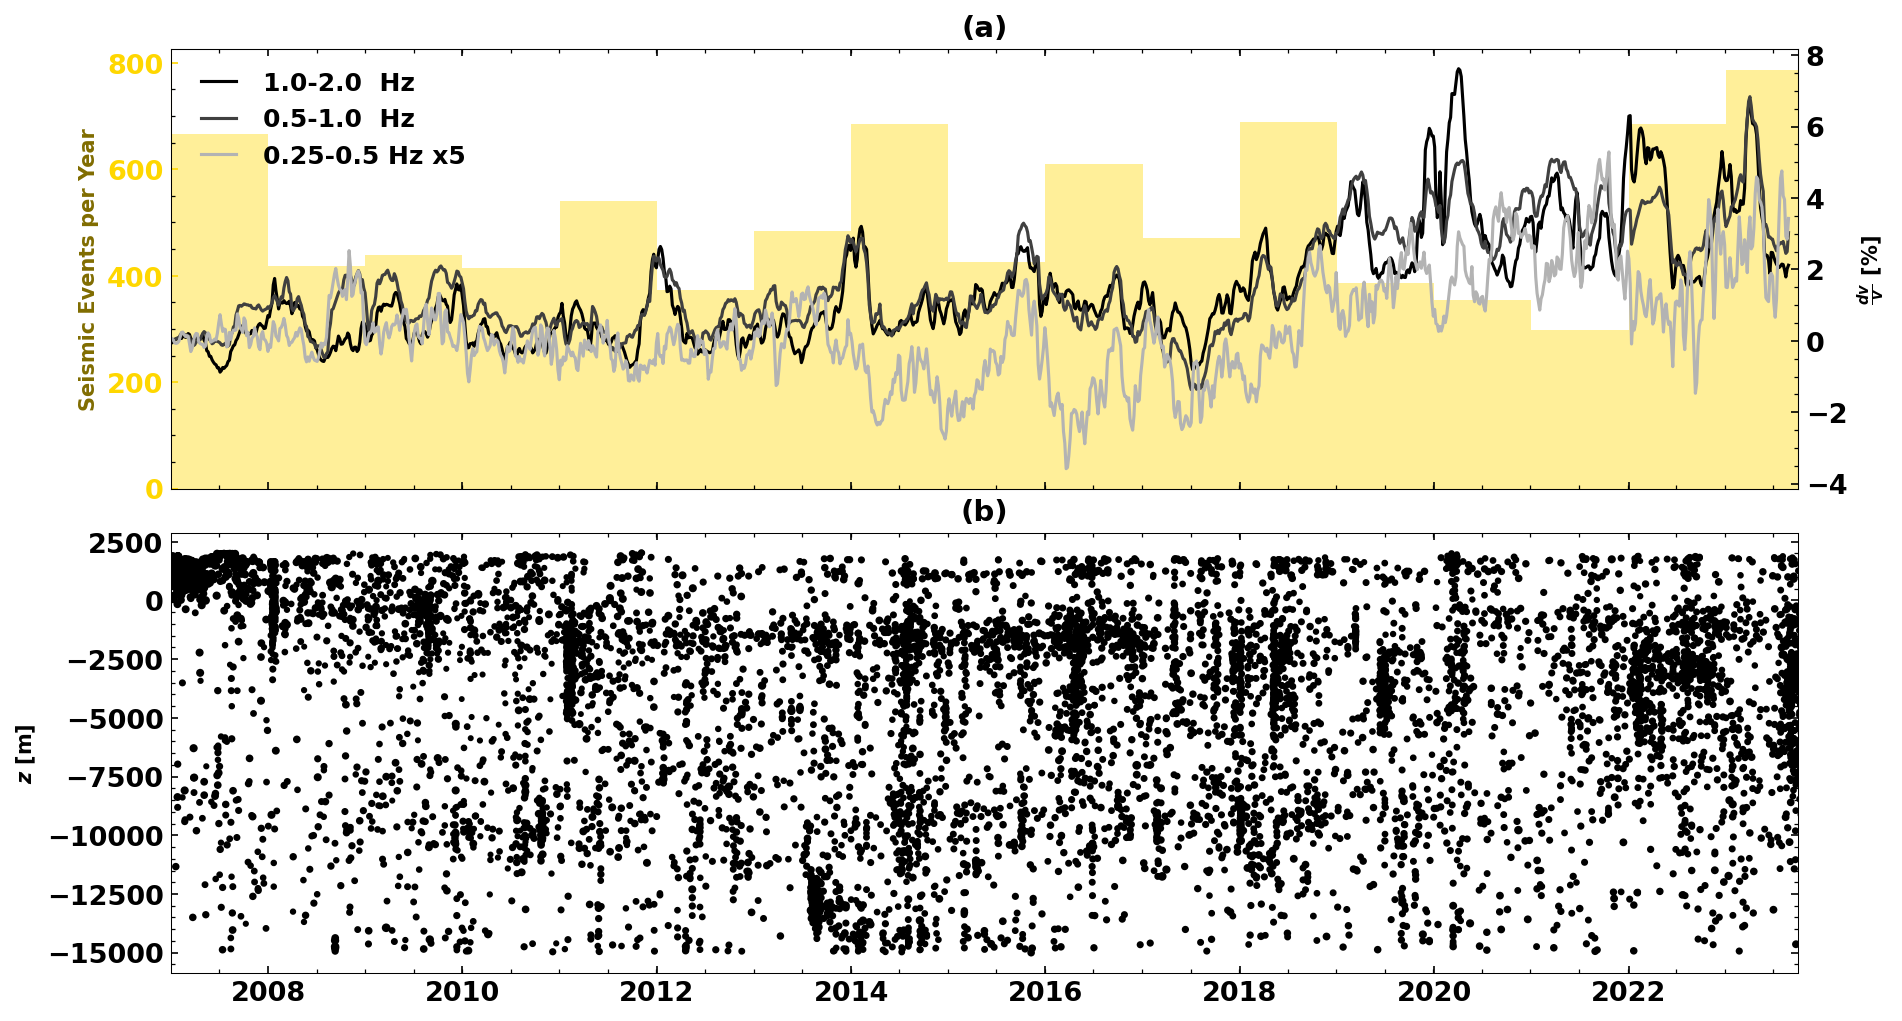

In [ ]:
from seismic.plot.plot_utils import set_mpl_params
import datetime
set_mpl_params()

outfolder = os.path.join(os.path.dirname(os.path.dirname(infile)), 'figures')

# plot dv/v for all frequencies

histcol = 'gold'

# difference
plt.figure(figsize=(14, 8))
ax0 = plt.subplot(2,1,1)
plt.ylabel('Seismic Events per Year')


# plot cumulative number of events
bins = [datetime.datetime(i, 1, 1) for i in np.arange(2007, 2025)]
otimes2 = [evt.preferred_origin().time.datetime for evt in evts if (evt.preferred_origin().depth < 2 and evt.preferred_origin().time.datetime > datetime.datetime(2009, 6, 1))]
otimes2.sort()
plt.hist(otimes, bins, zorder=1, color=histcol, histtype='stepfilled', alpha=.4);
plt.twinx()
colors = ['k', 'C1', 'C2']
for freq0, lighten_amount in zip([1.0, 0.5, 0.25], [1, .75, .3]):
    col = lighten_color('k', lighten_amount)
    if freq0 == 0.25:
        plt.plot(
            datetimes, dv[freq0]*5, label=f'{freq0}-{2*freq0} Hz x5',
            zorder=2, color=col)
        continue
    plt.plot(
        datetimes, dv[freq0], color=col,zorder=2, label=f'{freq0}-{2*freq0}  Hz')

# limit tick location to the right axis
ax01 = plt.gca()
ax01.yaxis.set_label_position("right")
ax01.yaxis.tick_right()

    
plt.ylabel(r'$\frac{dv}{v}$ [%]')
plt.legend()



ax1 = plt.subplot(2,1,2, sharex=ax0)
plt.ylabel(r'$z$ [m]')

# plot earthquake depths
hypz = [-evt.preferred_origin().depth for evt in evts]
plt.scatter(otimes, hypz, s=[(evt.preferred_magnitude().mag+3.1)*1.6 for evt in evts], color='k')


# ticks red
ax0.yaxis.label.set_color(lighten_color(histcol, 1.5))
ax0.spines['left'].set_color(histcol)  # Set spine color to red
ax0.tick_params(axis='y', colors=histcol)  # Set tick color to red

# remove the gap between the subplots
plt.subplots_adjust(hspace=0.1)
# titles
ax0.set_title('(a)')
ax1.set_title('(b)')

# remove upper x-label
plt.setp(ax0.get_xticklabels(), visible=False)

plt.xlim(datetime.datetime(2007, 1, 1), datetime.datetime(2023, 10, 1))
